<a href="https://colab.research.google.com/github/DrAlexSanz/nlpv2-course/blob/master/POS_tagging_in_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's do text classification with a simple RNN and then put a GRU and LSTM


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.model_selection import train_test_split

In [2]:
import nltk
from nltk.corpus import brown

In [3]:
nltk.download("brown")
nltk.download("universal_tagset")

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [4]:
corpus = brown.tagged_sents(tagset = "universal")

In [5]:
corpus

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [6]:
len(corpus)

57340

In [7]:
# Separate the list of lists of tuples in two lists

inputs = []
targets = []

for sentence_tag_pairs in corpus:
    tokens = []
    target = []

    for token, tag in sentence_tag_pairs:
        tokens.append(token)
        target.append(tag)
    inputs.append(tokens)
    targets.append(target)

In [8]:
train_inputs, test_inputs, train_targets, test_targets = train_test_split(inputs, targets, test_size = 0.3)

In [9]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = None # Get a unique tag for each word (no UNK)

should_lowercase = False

word_tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE, lower = should_lowercase, oov_token = "<UNK>") # Otherwise unks will be removed and len(input) != len(output). Then I get a misalignment in the outputs. Word 3 would get tag 4 and so on.
word_tokenizer.fit_on_texts(train_inputs)
train_inputs_int = word_tokenizer.texts_to_sequences(train_inputs)
test_inputs_int = word_tokenizer.texts_to_sequences(test_inputs)

In [10]:
# Get the word to integer mapping

word2idx = word_tokenizer.word_index
V = len(word2idx)
print("There are %s unique tokens" %V)

There are 47508 unique tokens


In [11]:
# Useful function from stackoverflow. It's a nested loop in a list comprehension format

def flatten(list_of_lists):
    flattened = [val for sublist in list_of_lists for val in sublist]
    return flattened

In [12]:
all_train_targets = set(flatten(train_targets))
all_train_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [13]:
all_test_targets = set(flatten(test_targets))
all_test_targets # And they all appear on the train and test sets.

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [14]:
# Check that I have all the tags in the train and test set. Otherwise the model won't learn/test one of them

all_train_targets == all_test_targets

True

In [15]:
# Convert targets to sequences

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_targets_int = tag_tokenizer.texts_to_sequences(train_targets)
test_targets_int =tag_tokenizer.texts_to_sequences(test_targets)

# Save for later

train_targets_int_unpadded = train_targets_int
test_targets_int_unpadded = test_targets_int

In [16]:
# Before padding: find max document length. Otherwise we can truncate inputs and that also would truncate targets

max_len_train = max(len(sent) for sent in train_inputs)
max_len_test = max(len(sent) for sent in test_inputs)
T = max((max_len_train, max_len_test))
max_len_train, max_len_test, T

(172, 180, 180)

In [17]:
# pad the sequences
train_inputs_int = pad_sequences(train_inputs_int, maxlen = T)
print("Shape of training data", train_inputs_int.shape)

Shape of training data (40138, 180)


In [18]:
# pad the sequences
test_inputs_int = pad_sequences(test_inputs_int, maxlen = T)
print("Shape of test data", test_inputs_int.shape)

Shape of test data (17202, 180)


In [19]:
# pad the tags too
train_targets_int = pad_sequences(train_targets_int, maxlen = T)
print("Shape of training tags", train_targets_int.shape)

# pad the tags too
test_targets_int = pad_sequences(test_targets_int, maxlen = T)
print("Shape of test tags", test_targets_int.shape)

Shape of training tags (40138, 180)
Shape of test tags (17202, 180)


In [20]:
# Number of classes

K = len(tag_tokenizer.word_index) + 1
K

13

In [21]:
# Define model

D = 13 # Because I can

i = Input(shape = (T,))
# mask_zero = True is much slower in GPU than CPU. Use CPU runtime
x = Embedding(V + 1, D, mask_zero = True)(i) # Ignore the zeros because that's a padding. Alternatively, build my own loss function and forget about this.
x = Bidirectional(LSTM(32, return_sequences = True))(x) # Bidirectional may help
x = Dense(K)(x)

model = Model(i, x)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180)]             0         
                                                                 
 embedding (Embedding)       (None, 180, 13)           617617    
                                                                 
 bidirectional (Bidirectiona  (None, 180, 64)          11776     
 l)                                                              
                                                                 
 dense (Dense)               (None, 180, 13)           845       
                                                                 
Total params: 630,238
Trainable params: 630,238
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(loss = SparseCategoricalCrossentropy(from_logits = True), optimizer = "adam", metrics = ["accuracy"])

In [ ]:
r = model.fit(train_inputs_int, train_targets_int, epochs = 5, validation_data = (test_inputs_int, test_targets_int))

Epoch 1/5
1255/1255 [==============================] - 253s 201ms/step - loss: 0.0490 - accuracy: 0.8719 - val_loss: 0.0145 - val_accuracy: 0.9610
Epoch 2/5
 182/1255 [===>..........................] - ETA: 4:31 - loss: 0.0108 - accuracy: 0.9718

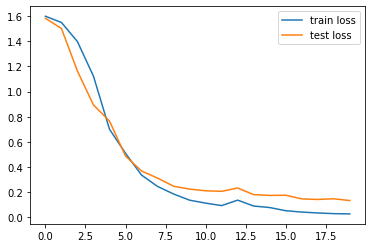

In [17]:
# See the loss and accuracy evolution

plt.plot(r.history["loss"], label = "train loss")
plt.plot(r.history["val_loss"], label = "test loss")
plt.legend()

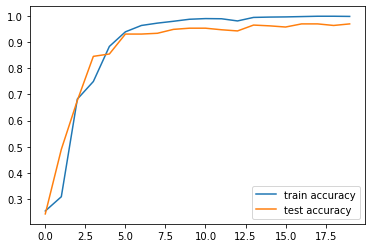

In [18]:
plt.plot(r.history["accuracy"], label = "train accuracy")
plt.plot(r.history["val_accuracy"], label = "test accuracy")
plt.legend()

Looks fine, test loss is worse than train loss and accuracy is worse too. But it includes padding.

In [ ]:
# To do, calculate the accuracy without taking the zeroes into account.